In [1]:
# ===============================
# 1. INSTALL DEPENDENCIES
# ===============================
!pip install --quiet tensorflow numpy pillow matplotlib

In [2]:
# Mount Google Drive to access your saved model and images
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# For heatmap overlay
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec

In [4]:
# ===============================
# 3. CUSTOM LEARNING RATE SCHEDULE
#    (REQUIRED TO LOAD YOUR MODEL)
# ===============================
@tf.keras.utils.register_keras_serializable()
class WarmUpExponentialDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr, decay_steps, decay_rate, warmup_steps):
        super(WarmUpExponentialDecay, self).__init__()
        self.initial_lr = initial_lr
        self.decay_steps = decay_steps
        self.decay_rate = decay_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        decay_steps = tf.cast(self.decay_steps, tf.float32)
        initial_lr = tf.cast(self.initial_lr, tf.float32)
        decay_rate = tf.cast(self.decay_rate, tf.float32)

        warmup_lr = initial_lr * (step / warmup_steps)
        decay_lr = initial_lr * tf.math.exp(-decay_rate * ((step - warmup_steps) / decay_steps))
        return tf.cond(step < warmup_steps, lambda: warmup_lr, lambda: decay_lr)

    def get_config(self):
        return {
            "initial_lr": self.initial_lr,
            "decay_steps": self.decay_steps,
            "decay_rate": self.decay_rate,
            "warmup_steps": self.warmup_steps
        }

In [5]:
# ===============================
# 4. LOAD YOUR TRAINED MODEL
# ===============================
model_path = '/content/drive/MyDrive/ML Project/TensorFlow/TF96.keras'
model = tf.keras.models.load_model(
    model_path,
    custom_objects={'WarmUpExponentialDecay': WarmUpExponentialDecay}
)

In [6]:
# ===============================
# 5. IMAGE PREPROCESSING
# ===============================
def load_and_preprocess_image(image_path, img_size=256):
    """
    Loads an image from disk, resizes to (img_size, img_size),
    scales pixel values to [0,1], and returns a tf.Tensor of shape (1, H, W, 3).
    """
    img = Image.open(image_path).convert('RGB')
    img = img.resize((img_size, img_size))
    img_array = np.array(img).astype('float32') / 255.0
    # Convert to tf.Tensor and add batch dimension
    img_tensor = tf.convert_to_tensor(img_array)        # shape (H, W, 3)
    img_tensor = tf.expand_dims(img_tensor, axis=0)     # shape (1, H, W, 3)
    return img_tensor

In [7]:
# ===============================
# 6. INTEGRATED GRADIENTS
# ===============================
def integrated_gradients(model, input_image, baseline=None, steps=100):
    """
    Computes Integrated Gradients for a given model and input image in float32.

    Args:
        model: A trained Keras model with output shape [batch, 1].
        input_image: tf.Tensor of shape (1, H, W, 3) in float32.
        baseline: Baseline image (same shape). If None, uses all zeros.
        steps: Number of interpolation steps between baseline and input.

    Returns:
        integrated_grads: A tf.Tensor of shape (H, W, 3) with attributions.
    """
    input_image = tf.cast(input_image, tf.float32)

    if baseline is None:
        baseline = tf.zeros_like(input_image, dtype=tf.float32)

    # Create a batch of scaled images
    scaled_imgs = []
    for i in range(steps + 1):
        alpha = i / steps
        interpolated = baseline + alpha * (input_image - baseline)
        scaled_imgs.append(interpolated)
    scaled_imgs = tf.concat(scaled_imgs, axis=0)  # (steps+1, H, W, 3)

    with tf.GradientTape() as tape:
        tape.watch(scaled_imgs)
        predictions = model(scaled_imgs)           # (steps+1, 1)
        predictions = tf.squeeze(predictions, axis=-1)  # (steps+1,)

    grads = tape.gradient(predictions, scaled_imgs)    # (steps+1, H, W, 3)
    avg_grads = tf.reduce_mean(grads, axis=0)          # (H, W, 3)

    # (input_image - baseline) => (1, H, W, 3), so squeeze to (H, W, 3)
    input_minus_baseline = tf.squeeze(input_image - baseline, axis=0)
    integrated_grads = input_minus_baseline * avg_grads  # (H, W, 3)

    return integrated_grads

In [8]:
# ===============================
# 7. HEATMAP OVERLAY FUNCTION
# ===============================
def overlay_heatmap_on_image(original, heatmap, alpha=0.4, colormap='jet'):
    """
    Overlays a heatmap (values between 0 and 1) on top of the original image.

    Args:
        original: float32 image array in [0,1], shape (H, W, 3).
        heatmap: float32 heatmap in [0,1], shape (H, W).
        alpha: blending factor (0.0 to 1.0).
        colormap: a valid matplotlib colormap name.

    Returns:
        overlay: float32 image array in [0,1], shape (H, W, 3).
    """
    cmap = cm.get_cmap(colormap)
    # Apply colormap to get RGBA values in [0,1]
    colored_hm = cmap(heatmap)[:, :, :3]  # (H, W, 3)
    # Combine original and heatmap
    overlay = (1 - alpha) * original + alpha * colored_hm
    return overlay

In [13]:
# ===============================
# 8. LOAD YOUR IMAGE, PREDICT, EXPLAIN
# ===============================
image_path = '/content/drive/MyDrive/ML Project/Test Images for HF/Fake/Obama Bin Laden.jpg'
input_image = load_and_preprocess_image(image_path, img_size=256)

# Convert to NumPy for plotting
original_image = input_image[0].numpy()  # shape (256, 256, 3), float32 in [0,1]

In [14]:
# Make prediction
pred = model.predict(input_image)
threshold = 0.5
predicted_label = int(pred[0][0] > threshold)
label_mapping = {0: "Real", 1: "Deepfake"}
pred_str = label_mapping[predicted_label]

print("Raw model output:", float(pred[0][0]))
print("Predicted label:", pred_str)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Raw model output: 0.8458840250968933
Predicted label: Deepfake


In [15]:
# Compute Integrated Gradients with more steps for finer approximation
ig = integrated_gradients(model, input_image, steps=100)
ig_abs = tf.math.abs(ig)
ig_map = tf.reduce_sum(ig_abs, axis=-1).numpy()

# Normalize IG heatmap to [0,1]
min_val, max_val = ig_map.min(), ig_map.max()
if max_val == min_val:
    max_val = min_val + 1e-8
ig_map = (ig_map - min_val) / (max_val - min_val)

# Gamma correction: use gamma > 1 to emphasize stronger attributions
gamma = 0.7
ig_map_gamma = ig_map ** gamma

# Compute various color visualizations
ig_hot = cm.get_cmap('hot')(ig_map_gamma)[:, :, :3]       # Raw IG using hot colormap
overlay_jet = overlay_heatmap_on_image(original_image, ig_map_gamma, alpha=0.5, colormap='jet')
ig_plasma = cm.get_cmap('plasma')(ig_map_gamma)[:, :, :3]   # IG with plasma colormap
ig_viridis = cm.get_cmap('viridis')(ig_map_gamma)[:, :, :3]   # IG with viridis colormap
ig_inferno = cm.get_cmap('inferno')(ig_map_gamma)[:, :, :3]   # IG with inferno colormap
ig_magma = cm.get_cmap('magma')(ig_map_gamma)[:, :, :3]       # IG with magma colormap

<ipython-input-15-fe14edfe35e2>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ig_hot = cm.get_cmap('hot')(ig_map_gamma)[:, :, :3]       # Raw IG using hot colormap
<ipython-input-15-fe14edfe35e2>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ig_plasma = cm.get_cmap('plasma')(ig_map_gamma)[:, :, :3]   # IG with plasma colormap
<ipython-input-15-fe14edfe35e2>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ig_viridis = cm.get_cmap('viridis')(ig_map_gamma

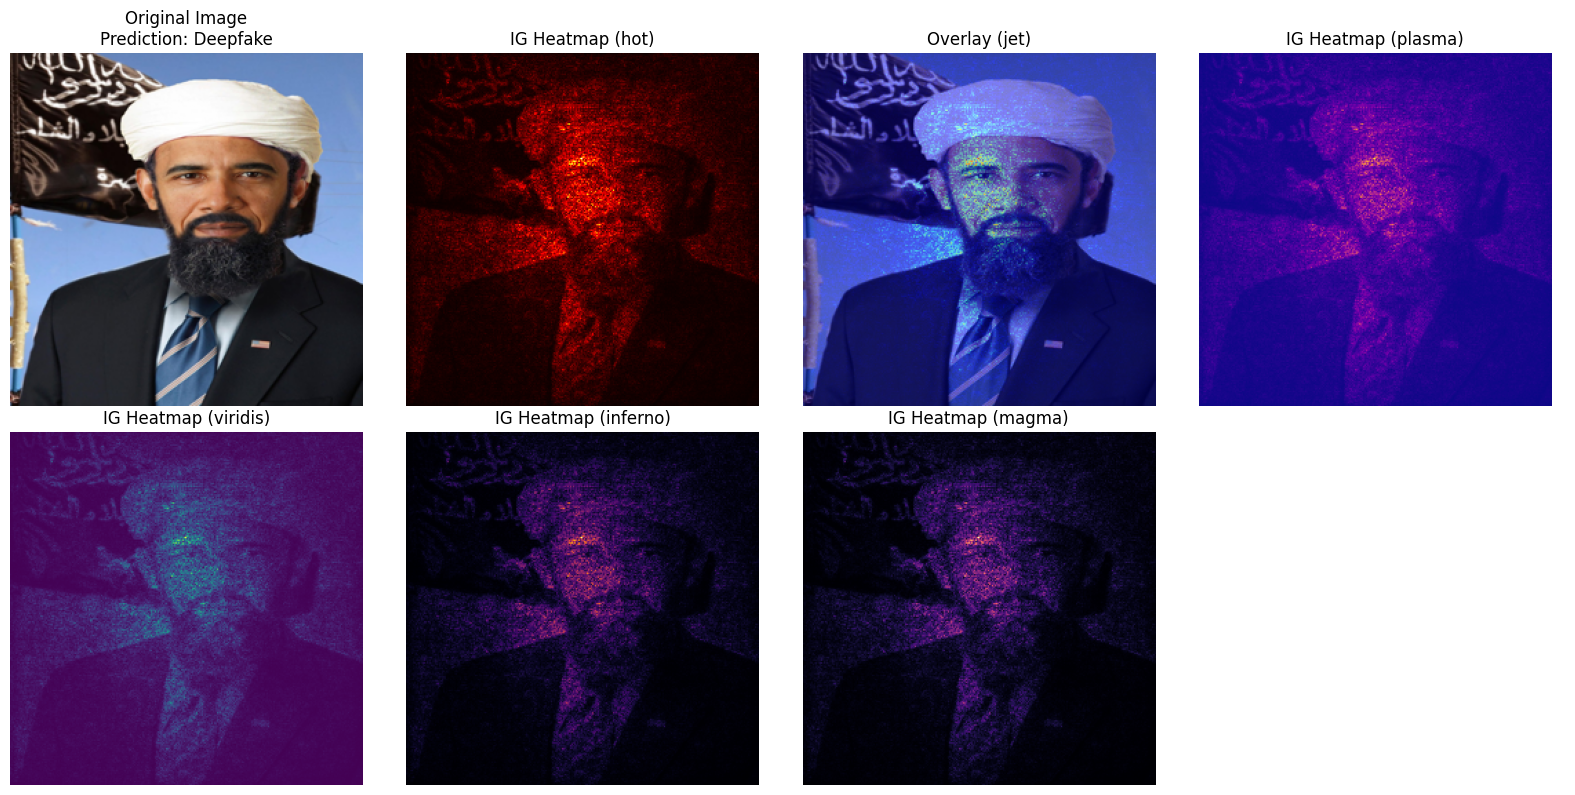

In [16]:
# ===============================
# 9. PLOT RESULTS IN A GRID (2 rows x 4 columns)
# ===============================
# We will display 7 images:
# 1. Original Image with Prediction
# 2. Raw IG Heatmap (hot)
# 3. Overlay Image (jet)
# 4. IG Heatmap (plasma)
# 5. IG Heatmap (viridis)
# 6. IG Heatmap (inferno)
# 7. IG Heatmap (magma)
# 8. Optional note

images = [
    (original_image, f"Original Image\nPrediction: {pred_str}"),
    (ig_hot, "IG Heatmap (hot)"),
    (overlay_jet, "Overlay (jet)"),
    (ig_plasma, "IG Heatmap (plasma)"),
    (ig_viridis, "IG Heatmap (viridis)"),
    (ig_inferno, "IG Heatmap (inferno)"),
    (ig_magma, "IG Heatmap (magma)"),
]

n_images = len(images)
ncols = 4
nrows = 2

fig, axs = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
axs = axs.flatten()

for i in range(n_images):
    img, title = images[i]
    axs[i].imshow(img)
    axs[i].set_title(title)
    axs[i].axis('off')

for j in range(n_images, nrows * ncols):
    axs[j].axis('off')

plt.tight_layout()
plt.show()